# Final Project Submission

- Student name: **PRISCILA WAIHIGA KAMIRI**
- Student pace: Full Time
- Scheduled project review date/time: 12-03-2023
- Instructor name: William Okomba

# Exploratory Data Analysis of Movie Datasets

## Introduction

As a data scientist,I have been tasked by **Microsoft** to conduct an **exploratory data analysis** (EDA) to generate insights on the movie industry. The project involves analyzing datasets to provide insights and recommendations.

![photo](https://raw.githubusercontent.com/waihiga9/Phase1_Project/main/Images/photo.jpeg)

## Business Understanding

 Microsoft have decided to create a new movie studio. Unfortunately, they have limited knowledge about creating movies. They need to gain understanding into the movie industry, such as the relationships between production budgets, revenues, ratings, genres and other key factors that contribute to the success of a movie.
 
 The goal of this project is to help Microsoft make data-driven decisions that will give them and opportunity to succeed in the highly competitive movie production industry.

## Data Understanding

In the folder `Data` contains movie datasets that will be used in the analysis of this project.

The datasets are from:
* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)


The datasets that will be used are:
1. `Data/im.db` and
2. `Data/tn.movie_budget.csv`

### IMDB

`Data/im.db` is a comprehensive database that constitutes information on movies content. It contains data on numerous titles and is organized into 8 tables:
- `persons`
- `writers`
- `directors`
- `known_for`
- `principals`
- `movie_basics`
- `movie_rating` 
- `movie_akas`

Below is the database's Entity Relationship Diagram 

![image](https://raw.githubusercontent.com/waihiga9/Phase1_Project/main/Images/movie_data_erd.jpeg)

### TheNumbers Dataset

`tn.movie_budget.csv` dataset contains the following columns:
 - `id` - movie id
 - `release_date` - date the movie was realeased
 - `movie` - movie name
 - `production_budget` - in dollars
 - `domestic_gross` - in dollars
 - `worldwide_gross` - in dollars

## Data Preparation

### `Data/im.db` database

IMDb database will be used to analyse the most popular genres in the movie industry and generate a frequency distribution of genres across all movies in the `movie_basics` table.
To understand the number of votes and average rate for each genre, we'll include the `movie_ratings`.
 
 Each record in the `movie_basics` and `movie_ratings` represents a single movie. There are approximately 146,000 and 74,000 movie records in the respective table.

Focus will be on `movie_id` feature which represents their ID, `genres` column that contains the genre or genres of the movie, separated by comma, `average_id` which gives the average ratings per movie, and finally `numvotes` which represents number of votes per genre.

#### Load Dataset

Load the necessary libraries, `pandas`, `numpy`, `sqlite3` and `seaborn`


In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Establish a connection to the database `Data/im.db`, called `conn`

In [2]:
conn = sqlite3.connect('Data/im.db')

View the table names

In [3]:
q = """
SELECT name
FROM sqlite_master
WHERE type = 'table'
"""
pd.read_sql(q, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Get the required columns from the tables and call DataFrame `rate_genre`

In [4]:
q = """
SELECT movie_id,
       genres,
       averagerating,
       numvotes
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
"""
genre_df = pd.read_sql(q, conn)
# overview of the data
print(genre_df.info())
# view the first 5 rows
genre_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   genres         73052 non-null  object 
 2   averagerating  73856 non-null  float64
 3   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB
None


,movie_id,genres,averagerating,numvotes
0,tt0063540,"Action,Crime,Drama",7.0,77
1,tt0066787,"Biography,Drama",7.2,43
2,tt0069049,Drama,6.9,4517
3,tt0069204,"Comedy,Drama",6.1,13
4,tt0100275,"Comedy,Drama,Fantasy",6.5,119


#### Data Cleaning

- **Missing values**

In [5]:
def identifying_missing_values(data):
    """Identify if the data has missing values"""
    # identify if data has missing values(data.isnull().any())
    # empty dict to store missing values
    missing = []
    for i in data.isnull().any():
        # add the bool values to empty list 
        missing.append(i)
    # covert list to set (if data has missing value, the list should have true and false)
    missing_set = set(missing)
    if (len(missing_set) == 1):
        out = print("The Data has no missing values")
    else:
        out = print("The Data has missing values.")

    return out

def missing_values(data):
    """A simple function to identify data has missing values"""
    # identify the total missing values per column
    # sort in order 
    miss = data.isnull().sum().sort_values(ascending = False)

    # calculate percentage of the missing values
    percentage_miss = (data.isnull().sum() / len(data)).sort_values(ascending = False)

    # store in a dataframe 
    missing = pd.DataFrame({"Missing Values": miss, "Percentage": percentage_miss})

    # remove values that are missing 
    missing.drop(missing[missing["Percentage"] == 0].index, inplace = True)

    return missing

identifying_missing_values(genre_df)
missing_values(genre_df)

The Data has missing values.


,Missing Values,Percentage
genres,804,0.010886


The `genres` column has 804 missing values which make up only 1% of the dataset. **Dropping the rows** is a safe choice here since our analysis is entirely based on the genres and replacing them with the most frequent value may alter our output accuracy

- **Duplicated values**

In [6]:
def identify_duplicates(data):
    """Simple function to identify any duplicates"""
    # identify the duplicates (dataframename.duplicated() , can add .sum() to get total count)
    # empty list to store Bool results from duplicated
    duplicates = []
    for i in data.duplicated():
        duplicates.append(i)
    # identify if there is any duplicates. (If there is any we expect a True value in the list duplicates)
    duplicates_set = set(duplicates) 
    if (len(duplicates_set) == 1):
        print("The Data has no duplicates")
    else:
        no_true = 0
        for val in duplicates:
            if (val == True):
                no_true += 1
        # percentage of the data represented by duplicates 
        duplicates_percentage = np.round(((no_true / len(data)) * 100), 3)
        print(f"The Data has {no_true} duplicated rows.\nThis constitutes {duplicates_percentage}% of the data set.") 



identify_duplicates(genre_df)

The Data has no duplicates


- **Column Data types**

In [7]:
genre_df.dtypes

movie_id          object
genres            object
averagerating    float64
numvotes           int64
dtype: object

- **Numeric column distribution**

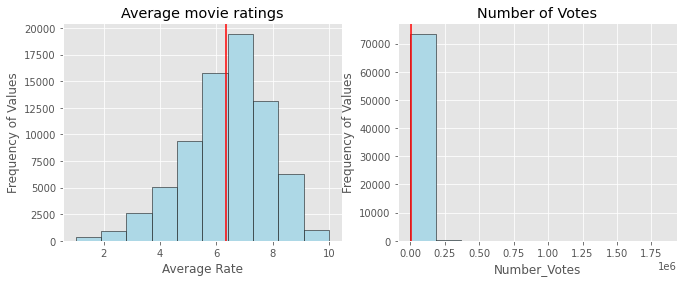

In [8]:
plt.style.use('ggplot') #grid view on plot
# create the plot
fig, (ax1, ax2) = plt.subplots(figsize = (11, 4), ncols = 2)

# plot `avaragerating` bar plot
ax1.hist(genre_df.averagerating, edgecolor = 'black', color = 'lightblue')
# adding a vertical line which represent the mean
ax1.axvline(np.mean(genre_df.averagerating), color = 'red', label = 'Average of averagerating')
# Set x and y axes lables and the title
ax1.set_xlabel('Average Rate')
ax1.set_ylabel('Frequency of Values')
ax1.set_title('Average movie ratings')

# Plot `numvotes` bar plot
ax2.hist(genre_df.numvotes, bins = 10, edgecolor = 'black', color = 'lightblue')
# adding a vertical line which represent the mean
ax2.axvline(np.mean(genre_df.numvotes), color = 'red', label = 'Average of number of votes')
# set x and y axes lables and the title
ax2.set_xlabel('Number_Votes')
ax2.set_ylabel('Frequency of Values')
ax2.set_title('Number of Votes');

*Interpretation of the average rating distribution*

In [9]:
print(f'The mean of the average movie ratings is: {round(np.mean(genre_df.averagerating), 2)} ')
print(f'The median of the average movie ratings is: {round(np.median(genre_df.averagerating), 2)} ')
print(f'The standard deviation of the average movie ratings is: {round(np.std(genre_df.averagerating), 2)}')

The mean of the average movie ratings is: 6.33 
The median of the average movie ratings is: 6.5 
The standard deviation of the average movie ratings is: 1.47


- The mean of the average movie ratings is `6.33`, which suggests that, on average, the movies are rated slightly above average.  The median of the average movie ratings is `6.5`, which means that half of the movies have a rating higher than 6.5 and half have a rating lower than 6.5. This measure of central tendency is less sensitive to extreme values than the mean and can be a more accurate representation of the "typical" rating.
- The **difference** between the mean and the median is relatively small `(0.17)`, which might suggest that the distribution is approximately symmetric, with a relatively small amount of negative skewness
- The standard deviation `(1.47)` indicates that there is some variability in the ratings. A larger standard deviation would suggest that the ratings are more spread out, while a smaller standard deviation would suggest that the ratings are more tightly clustered around the mean.

*Interpretation of the number of votes distribution*

In [10]:
print(f'The mean of the number of votes is: {round(np.mean(genre_df.numvotes), 2)} ')
print(f'The median of the number of votes is: {np.median(genre_df.numvotes)} ')
print(f'The standard deviation of the number of votes is: {round(np.std(genre_df.numvotes), 2)}')
print(f'The minimum number of votes is: {np.min(genre_df.numvotes)}')
print(f'The maximum number of votes is: {np.max(genre_df.numvotes)}')

The mean of the number of votes is: 3523.66 
The median of the number of votes is: 49.0 
The standard deviation of the number of votes is: 30293.82
The minimum number of votes is: 5
The maximum number of votes is: 1841066


- This distribution of the number of votes per movie suggests that the dataset is **highly positively skewed**, with a small number of movies receiving a large number of votes, while most movies receive only a few votes. The median of only 50 votes indicates that half of the movies in the dataset received fewer than 50 votes, while the *mean value is heavily influenced by the small proportion of movies with a large number of votes*.
- The high standard deviation suggests that the data is spread out over a wide range, with many outliers. The minimum value of 5 votes is quite low, indicating that there are many movies in the dataset that received very few votes. The maximum value of 1,841,066 votes is **much larger** than the mean or median, indicating that there are a few movies in the dataset that are **exceptionally popular**.
- The resulting skewness and outliers maybe be due to a combination of factors, including the popularity of certain movies, differences in release dates and marketing efforts, and the influence of user-generated content platforms, which may amplify the popularity of some movies while suppressing others.

Everything looks okay so far to continue with genre analysis.

However, The `genres` column needs more attention. Some of the entries represents more than one genres.

In [11]:
# investigate the number of unique genres
print(f"The current number of unique genres is: {genre_df.genres.nunique()}")

The current number of unique genres is: 923


In [12]:
# display the first 2 rows
genre_df.head(2)

,movie_id,genres,averagerating,numvotes
0,tt0063540,"Action,Crime,Drama",7.0,77
1,tt0066787,"Biography,Drama",7.2,43


- Using `rate_genre.explode()`

In [13]:
# transform values to a list structure
genre_df['genres'] = genre_df['genres'].str.split(',')
# explode
genre_df = genre_df.explode('genres')
# view the first 5 rows
genre_df.head()

,movie_id,genres,averagerating,numvotes
0,tt0063540,Action,7.0,77
0,tt0063540,Crime,7.0,77
0,tt0063540,Drama,7.0,77
1,tt0066787,Biography,7.2,43
1,tt0066787,Drama,7.2,43


In [14]:
# Checking the new number of unique genres
print(f"The number of unique genres is now: {genre_df.genres.nunique()}")

The number of unique genres is now: 26


**The dataset is ready for exploration**

### `Data/tn.movie_budgets.csv`

#### Load Dataset

In [15]:
# load the dataset and drop the id column
df1 = pd.read_csv('Data/tn.movie_budgets.csv').drop(columns=['id'])
# overview info of the dataset
print(df1.info())
# preview first 5 rows
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 226.0+ KB
None


,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


#### Data Cleaning

- **Columns Data Type**

In [16]:
df1

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
5777,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [17]:
df1.dtypes

release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

Converting `realease_date` into datetime format

In [18]:
df1['release_date'] = pd.to_datetime(df1['release_date'])

`production_budget`, `domestic_gross`, `worldwide_gross` to int64 data type

In [19]:
def convert_price_to_int64(df, column_name):
    # Remove commas and dollar signs from the column
    df[column_name] = df[column_name].str.replace(',', '', regex=False).str.replace('$', '', regex=False)
    # Convert to int64
    df[column_name] = df[column_name].astype('int64')
    return df

convert_price_to_int64(df1, 'production_budget')
convert_price_to_int64(df1, 'domestic_gross')
convert_price_to_int64(df1, 'worldwide_gross')

# inspect columns data types
df1.dtypes

release_date         datetime64[ns]
movie                        object
production_budget             int64
domestic_gross                int64
worldwide_gross               int64
dtype: object

- **Duplicated Values**

In [20]:
# check duplicated rows
identify_duplicates(df1)

The Data has no duplicates


- **Missing Values**

In [21]:
# identify missing values
identifying_missing_values(df1)

The Data has no missing values


- **Placeholders**

In [22]:
# check for number of rows with zero values
zero_values = df1.query('production_budget == 0 | domestic_gross == 0 | worldwide_gross == 0')
print(f'There are {len(zero_values)} rows with zero values.\nThis amounts to {round(len(zero_values)/len(df1)*100, 2)}% of the original dataset.')

There are 548 rows with zero values.
This amounts to 9.48% of the original dataset.


In [23]:
# drop rows with zero values in the 'production_budget', 'domestic_gross', and 'worldwide_gross' columns
df1 = df1.loc[(df1['production_budget'] != 0) & (df1['domestic_gross'] != 0) & (df1['worldwide_gross'] != 0)]

- **Numeric column distribution**

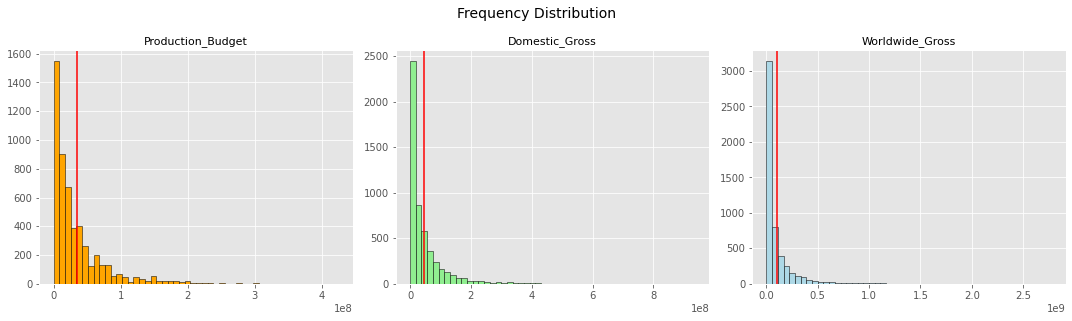

In [24]:
# create a figure with three subplots
fig, axes = plt.subplots(ncols=3, figsize=(15,4.5))

color_list = ['lightblue', 'pink', 'gray', 'gold', 'orange', 'lightgreen', 'cyan']
np.random.seed(00)
# plot a histogram for each column in the dataset
for i, ax in enumerate(axes):
    col_name = df1.columns[i+2]
    data = df1.loc[:, col_name]
    ax.hist(data, bins=50, edgecolor='black', color=np.random.choice(color_list))
    ax.axvline(data.mean(), color='red')
    ax.set_title(col_name.title(), fontsize=11)

# set the title for the entire figure
fig.suptitle('Frequency Distribution', fontsize=14)

# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.show()


The above frequency distribution suggests that the **mean values** of production budget, domestic gross, and worldwide gross are **greater than their respective median values**. This explains the right-skewed distribution as a few movies having very high production budgets and gross earnings, while the majority of movies have relatively lower budgets and earnings.

**The dataset is ready for exploration**

## Data Exploration and Visualization

### 1. What are top-rated popular genres?

- **Number of movies produced per genre**

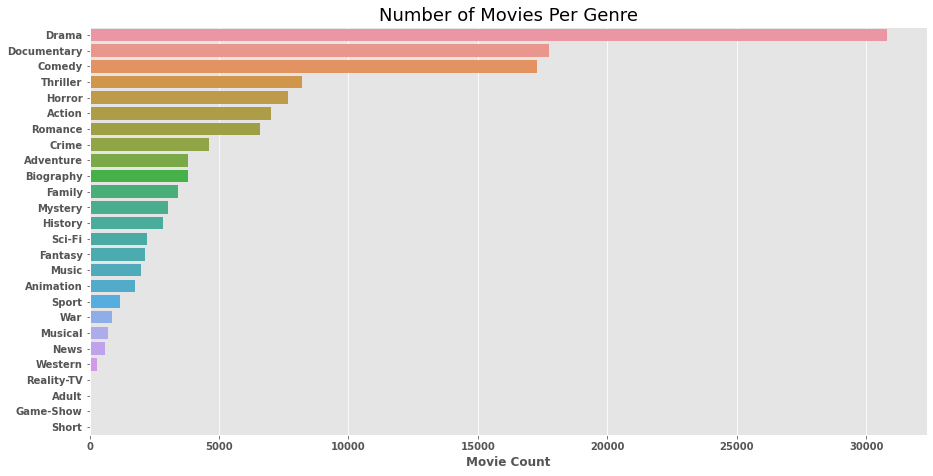

In [25]:
# set up plot
fig, ax = plt.subplots(figsize=(15,7.5))
# plot a count plot
sns.countplot(data=genre_df, y='genres', order=genre_df['genres'].value_counts().index)
# edit ticks font
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
# set labels and title
plt.xlabel('Movie Count', fontweight='bold')
plt.ylabel('')
plt.title('Number of Movies Per Genre', fontsize=18);


- **Average number of votes per Genre**

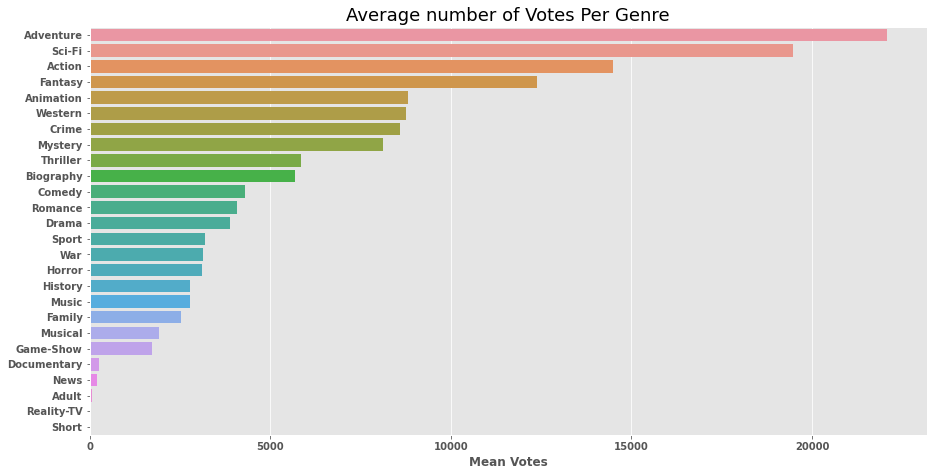

In [26]:
genre_votes = genre_df.groupby('genres')['numvotes'].mean().sort_values(ascending=False)
# set up plot
fig, ax = plt.subplots(figsize=(15, 7.5))
# plot the barchart
sns.barplot(y=genre_votes.index, x=genre_votes.values)
# edit ticks font
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
# set labels and title
ax.set_xlabel('Mean Votes', fontweight='bold')
ax.set_ylabel('')
ax.set_title('Average number of Votes Per Genre', fontsize=18);

- **Average rate per Genre for genres with more than 4000 movies and 3000 average votes** 

In [27]:
# group the data by genre and calculate the count of genre, mean of number of votes, and overall average mean
agg_df = genre_df.groupby('genres').agg({'genres': 'count', 'numvotes': 'mean','averagerating':'mean'})

# query and sort the data by the mean of averagerating
agg_df = agg_df.query('numvotes >= 3000 & genres >= 3000').sort_values(by='averagerating',ascending=False)
agg_df

,genres,numvotes,averagerating
genres,,,
Biography,3809,5673.259648,7.162274
Drama,30788,3883.574769,6.401559
Adventure,3817,22067.746660,6.196201
Romance,6589,4084.667324,6.146608
Crime,4611,8594.959011,6.115441
Comedy,17290,4297.617409,6.002689
Mystery,3039,8113.618295,5.920401
Action,6988,14476.485690,5.810361
Thriller,8217,5860.449434,5.639114


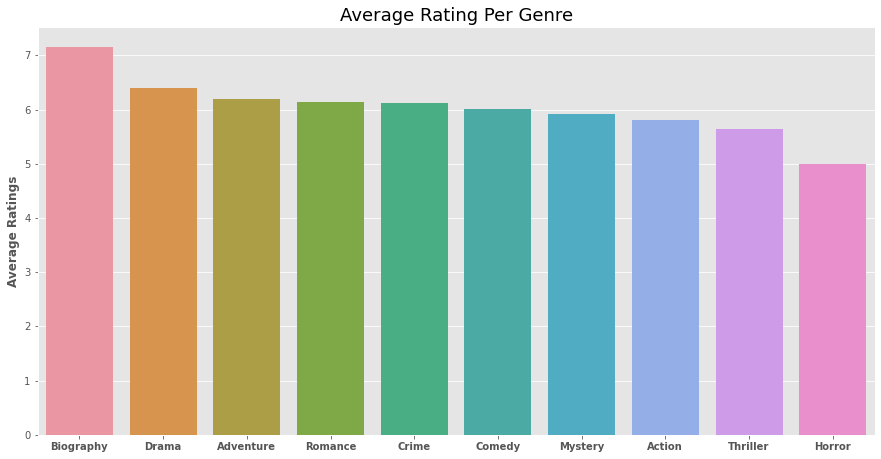

In [28]:
# Set up plot
fig, ax = plt.subplots(figsize=(15,7.5))
# plot barplot
sns.barplot(data=agg_df, x=agg_df.index, y=agg_df['averagerating'])
plt.xticks(fontweight='bold' )
ax.set_xlabel('')
ax.set_ylabel('Average Ratings', fontweight='bold')
ax.set_title('Average Rating Per Genre', fontsize=18);

Based on this analysis, it seems that the top-rated movie genres( above a rating of 6) with movies above 3000 and number of votes about 3000 are **Biography, Drama, Adventure, Romance, Crime and Comedy**. This could suggest that these genres are popular among movie audience and have a higher likelihood of being positively received by market.

Microsoft should explore the possibility of creating films within these genres as they have a higher likelihood of being positively received by audiences. However, these genres are highly competitive, and Microsoft need to make sure your movie stands out from the crowd.

### 2. What is the correlation between Production Budget and Gross?

Did the movies with the highest budget generate the highest revenue?

In [29]:
# correlation coefficients between production budget and revenue
corr_domestic = np.corrcoef(df1['production_budget'], df1['domestic_gross'])[0,1]
corr_worldwide = np.corrcoef(df1['production_budget'], df1['worldwide_gross'])[0,1]

# print the correlation coefficients
print('Correlation between production budget and domestic gross:', corr_domestic.round(2))
print('Correlation between production budget and worldwide gross:', corr_worldwide.round(2))

Correlation between production budget and domestic gross: 0.68
Correlation between production budget and worldwide gross: 0.74


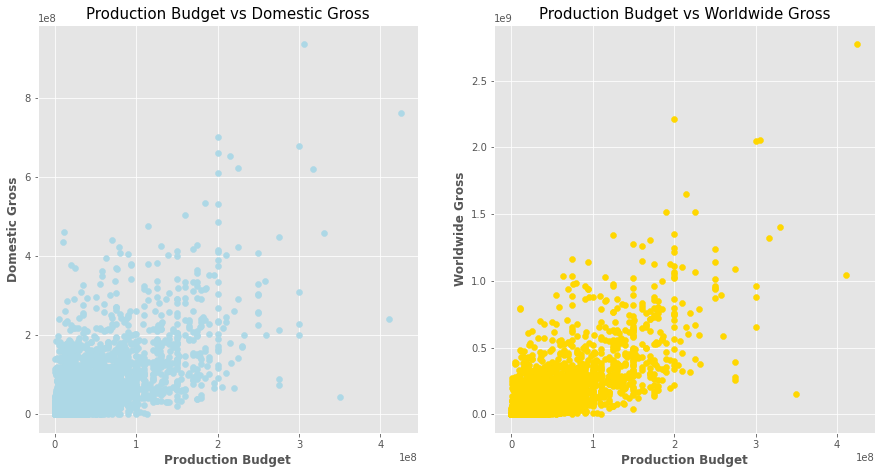

In [30]:
# create the plot
fig, axs = plt.subplots(1, 2, figsize=(15,7.5))
# plot scatter plot for production budget compared to domestic gross
axs[0].scatter(df1['production_budget'], df1['domestic_gross'], color = 'lightblue')
# Set x and y axes lables and the title
axs[0].set_xlabel('Production Budget', fontweight='bold')
axs[0].set_ylabel('Domestic Gross', fontweight='bold')
axs[0].set_title('Production Budget vs Domestic Gross', fontsize=15)

# plot scatter plot for production budget compared to worldwide gross
axs[1].scatter(df1['production_budget'], df1['worldwide_gross'], color = 'gold')
# set x and y axes lables and the title
axs[1].set_xlabel('Production Budget', fontweight='bold')
axs[1].set_ylabel('Worldwide Gross', fontweight='bold')
axs[1].set_title('Production Budget vs Worldwide Gross', fontsize=15)
plt.show()

The above correlation coefficients and the scatter plot indicate a ***moderately strong positive correlation*** between the production budget and both measures of gross.  This analysis argues that **movies with a higher production budget tend to earn more gross income.**

My recommendation for Microsoft would be to consider **investing a substantial amount of funds in the production budget**, as this could potentially result in higher revenue for their movies.


### 3. What is the trend of the Production Budget throughout the years?

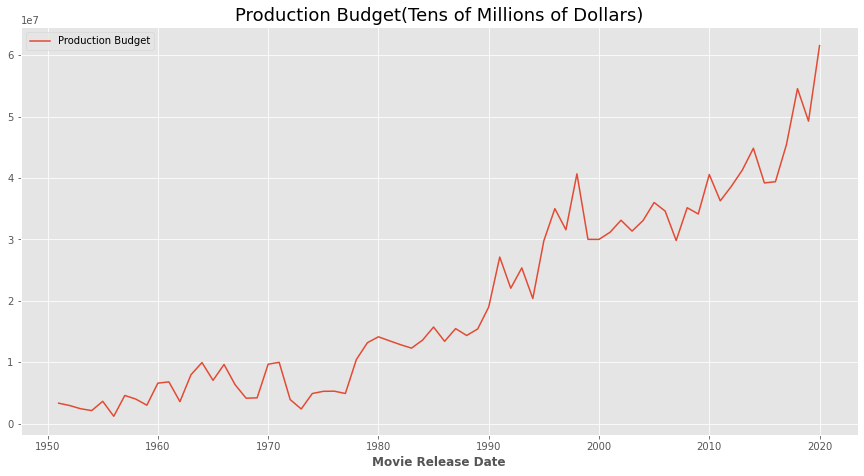

In [31]:
# filter the dataset to only include movies released in the last 10 years to avoid using outdated data for analysis
new_df = df1[df1['release_date'].dt.year >= 1950]

# group the dataset by months of release date and calculate the mean revenue for each month
yearly_budget = new_df.groupby(pd.Grouper(key='release_date', freq='Y'))['production_budget'].mean()

# create a time series graph of the yearly budget
fig, ax = plt.subplots(figsize=(15,7.5))
# plot the line plot
ax.plot(yearly_budget.index, yearly_budget.values, label='Production Budget')
# set x and y axes and the title
ax.set_xlabel('Movie Release Date', fontweight='bold')
ax.set_ylabel('')
ax.set_title('Production Budget(Tens of Millions of Dollars)', fontsize=18)
ax.legend()

plt.show()

Based on the trend of **increasing production budgets** in the film industry, I would recommend Microsoft to increase their production budget allocation for high-quality movie production compared to previous years. They could focus on top-notch cinematography, and sound design among others

### 4. Is there a seasonality trend of the release dates? When is the best time to release a movie?

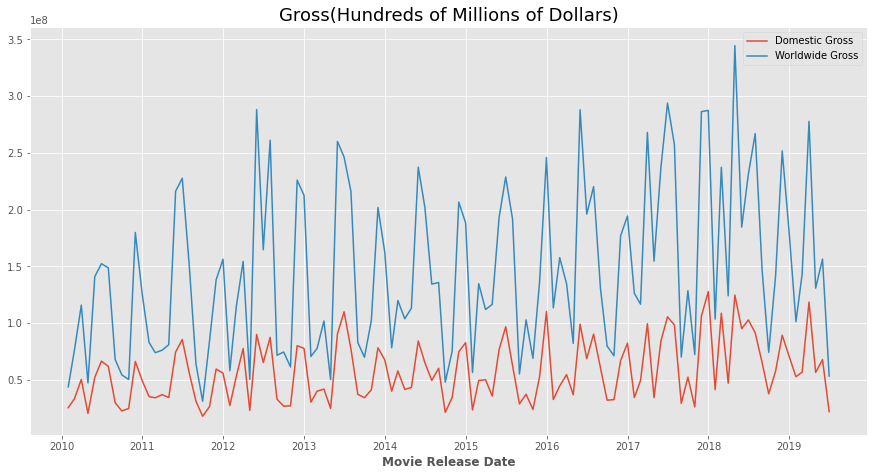

In [32]:
# filter the dataset to only include movies released in the last 10 years to avoid using outdated data for analysis
new_df = df1[df1['release_date'].dt.year >= 2010]

# group the dataset by months of release date and calculate the mean revenue for each month
monthly_revenue = new_df.groupby(pd.Grouper(key='release_date', freq='M'))[['domestic_gross', 'worldwide_gross']].mean()

# create a time series graph of the monthly gross
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(monthly_revenue.index, monthly_revenue['domestic_gross'], label='Domestic Gross')
ax.plot(monthly_revenue.index, monthly_revenue['worldwide_gross'], label='Worldwide Gross')
ax.set_xlabel('Movie Release Date', fontweight='bold')
ax.set_ylabel('')
ax.set_title('Gross(Hundreds of Millions of Dollars)', fontsize=18)
ax.legend()

plt.show()

Based on the trend in the time series plot, it appears that the gross income for movies tends to be **higher during the mid months of the year**, which could correspond to the **summer period of the northern hemisphere**. This is a common trend in the movie industry, as many people tend to have more free time during the summer months and are more likely to go to the movies.

Therefore, I would recommend that Microsoft consider releasing their movies during the mid months of the year, particularly in the summer months. This could increase the chances of their movies being successful and generating higher revenue.

### 5. What is the difference between Domestic Gross and Worldwide Gross?

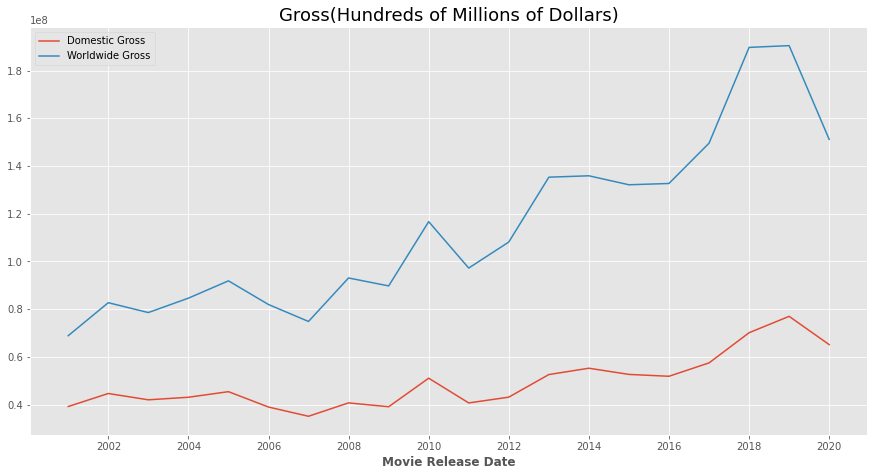

In [33]:
# filter the dataset to only include movies released in the last 10 years to avoid using outdated data for analysis
new_df = df1[df1['release_date'].dt.year >= 2000]

# group the dataset by months of release date and calculate the mean revenue for each month
yearly_gross = new_df.groupby(pd.Grouper(key='release_date', freq='Y'))[['domestic_gross', 'worldwide_gross']].mean()

# create a time series graph of the yearly gross
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(yearly_gross.index, yearly_gross['domestic_gross'], label='Domestic Gross')
ax.plot(yearly_gross.index, yearly_gross['worldwide_gross'], label='Worldwide Gross')
ax.set_xlabel('Movie Release Date', fontweight='bold')
ax.set_ylabel('')
ax.set_title('Gross(Hundreds of Millions of Dollars)', fontsize=18)
ax.legend()

plt.show()

By **comparing the domestic and worldwide gross**, it is evident that **movies performed well in a global market**. This could indicate that the most movies had a broad appeal that could be successful in multiple regions.

Based on this analysis, to maximize revenue, it may be beneficial for Microsoft to **create movies with broad international appeal**. This could involve incorporating elements that are **popular across different cultures and languages** as well as **targeting marketing efforts towards international audiences**.

## Conclusion

In conclusion, the analysis of the movie datasets has provided us with valuable insights into the movie industry. We have:
- identified most popular genres 
- investigated the role of production budget in the success of movies
- analyzed production budget trend
- explored how release dates can affect revenue and
- examined domestic versus global revenue

Finally, I would recommend:
- Explore the possibility of creating films within the genres of Biography, Drama, Adventure, Romance, Crime, and Comedy.
- Invest a substantial amount of funds in the production budget.
- Increase the production budget allocation for high-quality movie production compared to previous years.
- Consider releasing the movies during the mid months of the year, particularly in the summer months.
- Produce globally appealing movies and market them to international audiences.
